In [1]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 6.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16444 sha256=24925748c319224a4bdc39163f785ee96e60032b3496acdb7f9c86be274213fa
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60962 sha256=be75ff91472d79440ed40332d84a8b3ae4c41aedb6a2dd9ff574eabffb6272f8
  Stored in directory: /root/.cache/pip/w

In [64]:
model = smp.Unet(
    encoder_name="mobilenet_v2",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=2                    # model output channels (number of classes in your dataset)
).cuda().train()

In [3]:
!pip install -q kaggle
!cp kaggle.json ~/.kaggle/
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d balraj98/massachusetts-roads-dataset

cp: cannot stat 'kaggle.json': No such file or directory


Saving kaggle.json to kaggle.json
100% 5.76G/5.76G [02:28<00:00, 37.1MB/s]
100% 5.76G/5.76G [02:28<00:00, 41.6MB/s]


In [4]:
!unzip massachusetts-roads-dataset.zip
!rm -rf massachusetts-roads-dataset.zip

Archive:  massachusetts-roads-dataset.zip
  inflating: label_class_dict.csv    
  inflating: metadata.csv            
  inflating: tiff/test/10378780_15.tiff  
  inflating: tiff/test/10828720_15.tiff  
  inflating: tiff/test/11128870_15.tiff  
  inflating: tiff/test/11278840_15.tiff  
  inflating: tiff/test/11728825_15.tiff  
  inflating: tiff/test/12328750_15.tiff  
  inflating: tiff/test/15928855_15.tiff  
  inflating: tiff/test/16078870_15.tiff  
  inflating: tiff/test/17878735_15.tiff  
  inflating: tiff/test/17878780_15.tiff  
  inflating: tiff/test/17878885_15.tiff  
  inflating: tiff/test/18028750_15.tiff  
  inflating: tiff/test/18178780_15.tiff  
  inflating: tiff/test/18328735_15.tiff  
  inflating: tiff/test/18328780_15.tiff  
  inflating: tiff/test/18328960_15.tiff  
  inflating: tiff/test/18478735_15.tiff  
  inflating: tiff/test/18478900_15.tiff  
  inflating: tiff/test/18478930_15.tiff  
  inflating: tiff/test/20278885_15.tiff  
  inflating: tiff/test/20728960_15.tiff  


In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import os

In [47]:
def checkimage(img,lab):
  imgn = np.array(img.getdata())
  labn = np.array(lab.getdata())
  return imgn.sum((0,1))<0.8*imgn.shape[0]*imgn.shape[1]*255 and labn.sum(0)>0.1*labn.shape[0]*255

In [50]:
!rm -rf new/train
!rm -rf new/train_labels

In [19]:
os.mkdir('new')

In [51]:
#parse dataset

image_size = 256
pth = 'train'
src_path =  './tiff/'+pth
label_src_path = './tiff/'+pth+'_labels'
dst_path = './new/'+pth
label_dst_path = './new/'+pth+'_labels'

os.mkdir(dst_path)

os.mkdir(label_dst_path)

image_names = os.listdir(src_path)
image_names.sort()
s_image_names = os.listdir(label_src_path)
s_image_names.sort()

cnt = 0
for (name,lab_name) in zip(image_names,s_image_names):
  path = os.path.join(src_path,name)
  label_path = os.path.join(label_src_path,lab_name)
  img = Image.open(path)
  lab_img = Image.open(label_path)

  size = int(img.size[0]/image_size)
  pad = cnt*(size+1)*(size+1)
  for i in range(size):
    for j in range(size):
      new_img = img.crop((image_size*i,image_size*j,image_size*(i+1),image_size*(j+1)))
      new_lab_img = lab_img.crop((image_size*i,image_size*j,image_size*(i+1),image_size*(j+1)))
      if checkimage(new_img,new_lab_img):
        new_img.save(dst_path+f'/{i*size+j+pad}.tiff')
        new_lab_img.save(label_dst_path+f'/{i*size+j+pad}.tif')

    if size*image_size!=img.size[0]:
      new_img = img.crop((img.size[0]-image_size,image_size*i,img.size[0],image_size*(i+1)))
      new_lab_img = lab_img.crop((img.size[0]-image_size,image_size*i,img.size[0],image_size*(i+1)))
      if checkimage(new_img,new_lab_img):
        new_img.save(dst_path+f'/{size*size+i+pad}.tiff')
        new_lab_img.save(label_dst_path+f'/{size*size+i+pad}.tif')

  for i in range(size):
    new_img = img.crop((image_size*i,img.size[0]-image_size,image_size*(i+1),img.size[0]))
    new_lab_img = lab_img.crop((image_size*i,img.size[0]-image_size,image_size*(i+1),img.size[0]))
    if checkimage(new_img,new_lab_img):
      new_img.save(dst_path+f'/{size*(size+1)+i+pad}.tiff')
      new_lab_img.save(label_dst_path+f'/{size*(size+1)+i+pad}.tif')

  new_img = img.crop((img.size[0]-image_size,img.size[0]-image_size,img.size[0],img.size[0]))
  new_lab_img = lab_img.crop((img.size[0]-image_size,img.size[0]-image_size,img.size[0],img.size[0]))
  if checkimage(new_img,new_lab_img):
    new_img.save(dst_path+f'/{(size+1)*(size+1)+pad}.tiff')
    new_lab_img.save(label_dst_path+f'/{(size+1)*(size+1)-1 + pad}.tif')
  if cnt%max(int(len(image_names)/200),1)==int(len(image_names)/200)-1:
    print(cnt/len(image_names)*100)
  cnt+=1
  

0.36101083032490977
0.8122743682310468
1.263537906137184
1.7148014440433215
2.166064981949458
2.6173285198555956
3.068592057761733
3.5198555956678703
3.9711191335740073
4.422382671480144
4.873646209386282
5.324909747292419
5.776173285198556
6.227436823104693
6.678700361010831
7.129963898916968
7.581227436823104
8.032490974729242
8.483754512635379
8.935018050541517
9.386281588447654
9.83754512635379
10.288808664259928
10.740072202166065
11.191335740072201
11.64259927797834
12.093862815884476
12.545126353790614
12.996389891696749
13.447653429602887
13.898916967509026
14.350180505415164
14.801444043321299
15.252707581227437
15.703971119133575
16.15523465703971
16.60649819494585
17.057761732851986
17.509025270758123
17.96028880866426
18.4115523465704
18.862815884476532
19.314079422382672
19.76534296028881
20.216606498194945
20.667870036101082
21.119133574007222
21.57039711191336
22.021660649819495
22.47292418772563
22.92418772563177
23.375451263537904
23.826714801444044
24.27797833935018
2

In [67]:
class dataset(torch.utils.data.Dataset):
  def __init__(self,data_folder_name,label_folder_name,transform_=None):
    super().__init__()
    self.data_folder_name_ = data_folder_name
    self.label_folder_name_ = label_folder_name
    self.data_files = os.listdir(self.data_folder_name_)
    self.data_files.sort()
    self.label_files = os.listdir(self.label_folder_name_)
    self.label_files.sort()
    self.transform = transform_
  def __len__(self):
    return len(self.data_files)
  def __getitem__(self,idx):
      img_path = os.path.join(self.data_folder_name_,self.data_files[idx])
      image = Image.open(img_path)
      label_path = os.path.join(self.label_folder_name_,self.label_files[idx])
      label = Image.open(label_path)
      if self.transform:
          image = self.transform(image)
          label = self.transform(label)
      return image, label.long()[0]

In [66]:
data_transforms =transforms.Compose([
        transforms.ToTensor()
    ])
batch_size = 32
train_data = dataset("new/train","new/train_labels",data_transforms)
train_dataloader = DataLoader(train_data,batch_size=batch_size)


valid_data = dataset("new/val","new/val_labels",data_transforms)
valid_dataloader = DataLoader(valid_data,batch_size=batch_size)

In [24]:
get_stats = smp.metrics.functional.get_stats
IOU = smp.metrics.iou_score

In [71]:
import gc
torch.cuda.empty_cache()
gc.collect()

47098

In [69]:

criterion = smp.losses.FocalLoss('multiclass',gamma=0)
optimizer = torch.optim.Adamax(model.parameters(),weight_decay=1e-04)

image_example=train_data[0][1].shape
image_size = 1
for i in image_example:
  image_size*=i

val_iou_per_epoch = []
iou_per_epoch = []


for epoch in range(10):
    running_loss = 0.0

    iou_score = 0
    for i,data in enumerate(train_dataloader, 0):
        x, label = data
        x = x.cuda()
        label = label.cuda()

        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        TP,FP,FN,TN = get_stats(y.argmax(dim=1),label,'multiclass',num_classes=2)
        iou_score += IOU(TP,FP,FN,TN,'micro').item()
        if i % 10 == 9:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            running_loss=0
    iou_per_epoch.append(iou_score/len(train_data))
    
    iou_score = 0
    for i,data in enumerate(valid_dataloader, 0):
        x, label = data
        x = x.cuda()
        label = label.cuda()
        y = model(x)
        TP,FP,FN,TN = get_stats(y.argmax(dim=1),label,'multiclass',num_classes=2)
        iou_score += IOU(TP,FP,FN,TN,'micro').item() 
    val_iou_per_epoch.append(iou_score/len(valid_data))

[1,    10] loss: 0.822
[1,    20] loss: 0.777
[1,    30] loss: 0.789
[1,    40] loss: 0.747
[1,    50] loss: 0.754
[1,    60] loss: 0.758
[1,    70] loss: 0.794
[1,    80] loss: 0.778
[1,    90] loss: 0.782
[1,   100] loss: 0.807
[1,   110] loss: 0.806
[1,   120] loss: 0.845
[1,   130] loss: 0.798
[1,   140] loss: 0.758
[1,   150] loss: 0.778
[1,   160] loss: 0.745
[2,    10] loss: 0.813
[2,    20] loss: 0.776
[2,    30] loss: 0.789
[2,    40] loss: 0.746
[2,    50] loss: 0.753
[2,    60] loss: 0.757
[2,    70] loss: 0.793
[2,    80] loss: 0.778
[2,    90] loss: 0.782
[2,   100] loss: 0.806
[2,   110] loss: 0.806
[2,   120] loss: 0.844
[2,   130] loss: 0.797
[2,   140] loss: 0.758
[2,   150] loss: 0.777
[2,   160] loss: 0.744
[3,    10] loss: 0.812
[3,    20] loss: 0.776
[3,    30] loss: 0.788
[3,    40] loss: 0.745
[3,    50] loss: 0.752
[3,    60] loss: 0.757
[3,    70] loss: 0.793
[3,    80] loss: 0.778
[3,    90] loss: 0.782
[3,   100] loss: 0.806
[3,   110] loss: 0.806
[3,   120] 

KeyboardInterrupt: ignored

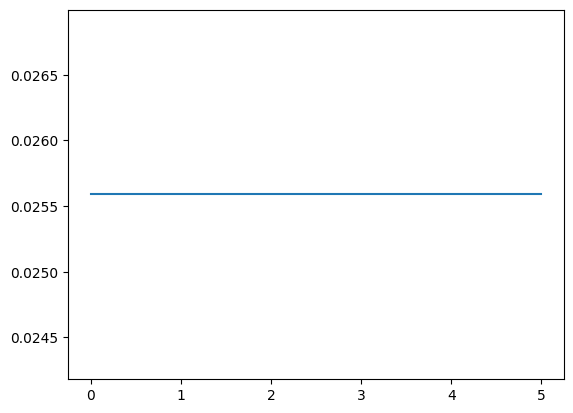

In [62]:
import matplotlib.pyplot as plt

plt.plot(val_iou_per_epoch)

In [ ]:
plt.plot(iou_per_epoch)

torch.Size([256, 256])


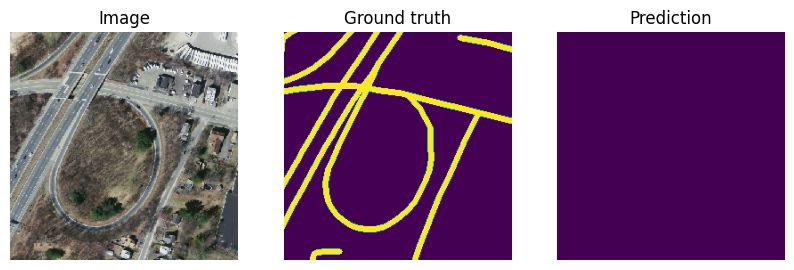

torch.Size([256, 256])


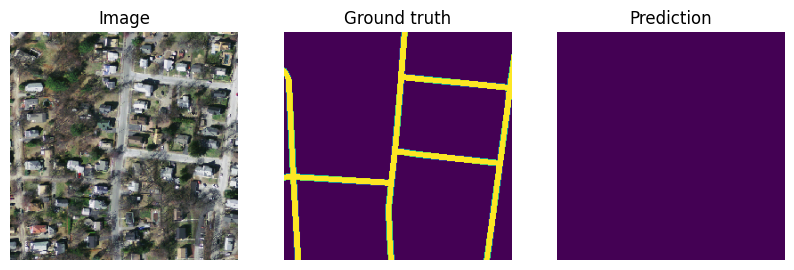

torch.Size([256, 256])


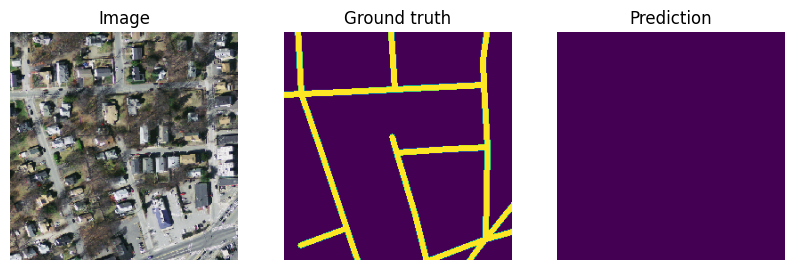

torch.Size([256, 256])


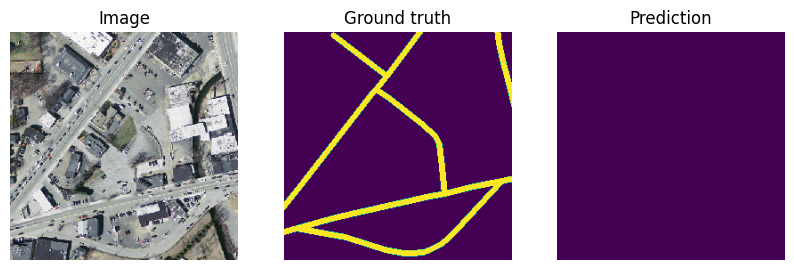

torch.Size([256, 256])


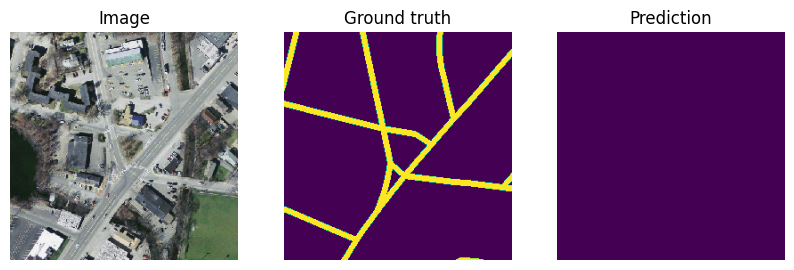

torch.Size([256, 256])


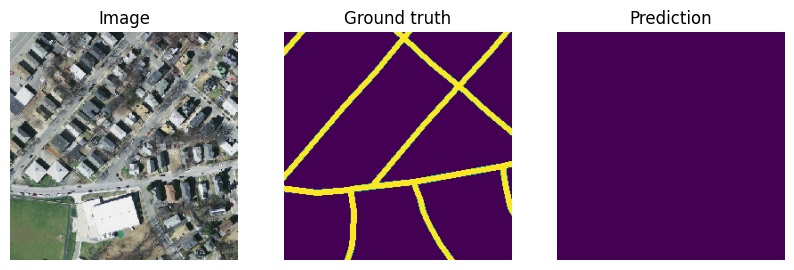

In [70]:
valid_test_loader = DataLoader(train_data,batch_size=1)
with torch.no_grad():
  model = model.eval()
  for i,data in enumerate(valid_test_loader, 0):
    x, label = data
    x_copy = x[0]
    x = x.cuda()
    y = model(x)[0].to('cpu').argmax(dim=0)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    print(y.shape)
    plt.imshow(x_copy.numpy().transpose(1, 2, 0)) # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(label.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(y.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    plt.show()
    if i==5:
      break

In [ ]:
arr = os.listdir('tiff/train')
arr.sort()
arr[277]

'17278870_15.tiff'